In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import requests
import json

# matplotlib.pyplot for data plots
import matplotlib.pyplot as plt

# sklearn for machine learning methods
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


df = pd.read_excel('data/companies.xlsx')

# Drop the companies without available quantitative data for machine learning
df = df.dropna()

df


,company,cvr,2022,2021,2020,employees,address
0,NorthTech ApS,10121361,5.0,598.0,792.0,20,"Wildersgade 51, København K"
1,PFA,13594376,-79000.0,108000.0,10000.0,1464,"Sundkrogsgade 4, København Ø"
2,Netcompany A/S,14814833,583573.0,570944.0,450133.0,2340,"Grønningen 17, København K"
3,Elbek-vejrup,20117982,43935.0,54376.0,44403.0,171,"Tangen 6, Aarhus N"
4,ELLAB A/S,20896949,136500.0,98092.0,90317.0,166,"Trollesmindealle 25, Hillerød"
5,Wilke A/S,21830445,3834.0,2006.0,1561.0,175,"Gråbrødrepassagen 9, Odense C"
6,Novo Nordisk,24256790,47523000.0,42159000.0,39252000.0,22150,"Novo Alle 1, Bagsværd"
7,KMD A/S,26911745,53926.0,2893.0,173758.0,1855,"Lautrupparken 40, Ballerup"
8,Alpha Solutions,27506488,3477.0,4334.0,-2940.0,59,"Gothersgade 14, København K"
9,Formpipe,29177015,36583.0,14719.0,7525.0,87,"Lautrupvang 1, Ballerup"


In [2]:
# Method to predict the latest yearly result based on the previous and the before for a single company

def predict_2022_result(company_name) :
    row = df[df['company'] == company_name].iloc[0]
    
    # Define the X and Y values for linear regression
    X = [[2020], [2021]]
    y = [row[2020], row[2021]]

    # Create a Linear Regression model and fit it to your data
    model = LinearRegression()
    model.fit(X, y)
    
    # Use the model to make a prediction for 2021
    prediction = model.predict([[2022]])
    
    # Plot the data and the line of best fit
    plt.scatter(X, y)
    plt.plot(X, model.predict(X), color='red')
    plt.plot([[2022]], prediction, 'ro')
    plt.xlabel('Year')
    plt.ylabel('Income')
    plt.title('Linear Regression')
    plt.xticks(rotation=90)
    plt.show()
    
    #R-Squared
    r_squared = model.score(X, y)
    print(f"R-squared value: {r_squared}")

    # Return the prediction
    return f'Expected income of 2022: {int(prediction)}000 DKK \nActual income of 2022: {int(row[2022])}000 DKK'

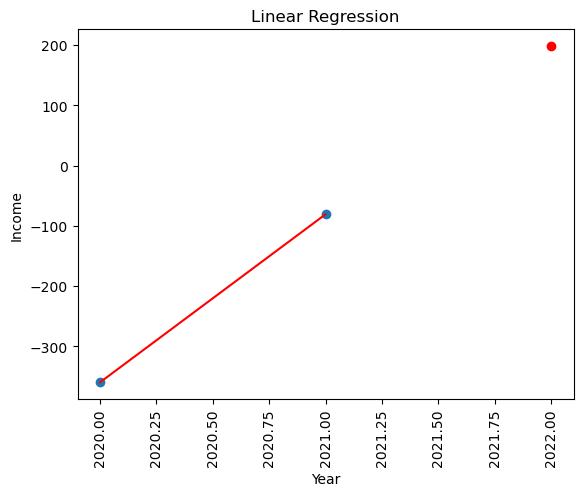

R-squared value: 1.0
Expected income of 2022: 198000 DKK 
Actual income of 2022: 451000 DKK


In [3]:
# Call the method
print(predict_2022_result('Meew'))

### Categorize the companies as Small, Middle or Large
We will base the size of a company on the amount of employees according the the European standards. 

**Employees:**
1. Companies with fewer than 50 employees are regarded as small
2. Companies with fewer than 250 employees are regarded as medium
3. Companes above 250 employees are regarded as large

**Yearly income:**
1. Companies with an annual turnover of less than 75 million DKK is regarded as small
2. Companies with an annual turnover of less than 375 million DKK is regarded as medium
3. Companies with an annual turnover of more than 375 million DKK is regarded as large

In [4]:
#Get lists of small companies and their address so we can pass it through a geolocation library.
small_company_names = []
small_company_addresses = []
small_company_income = []
small_company_employees = []

for index, row in df.iterrows():
    if row['employees'] < 50 and row[2022] < 75000:
        small_company_names.append(row['company'])
        small_company_addresses.append(row['address'])
        small_company_income.append(row[2022])
        small_company_employees.append(row['employees'])

In [5]:
# Add municipality to every company

# To get each municipality by address, we can use the Dawa API and pass each addresss

# Dawa API URL
url = "https://dawa.aws.dk/adresser"

small_company_municipalities = []

for address in small_company_addresses:
    query = address
    response = requests.get(url, params={"q": query})
    data = json.loads(response.content)
    small_company_municipalities.append(data[0]['adgangsadresse']['kommune']['navn'])

# Create dataframe
data = {'company': small_company_names, 'address': small_company_addresses, 'municipality': small_company_municipalities, 'income': small_company_income, 'employees': small_company_employees}
small_company_df = pd.DataFrame(data)

small_company_df

,company,address,municipality,income,employees
0,NorthTech ApS,"Wildersgade 51, København K",København,5.0,20
1,Carve Consulting P/S,"Købmagergade 11, København K",København,3821.0,46
2,Precure,"Bryggeristræde 2, Allinge",Bornholm,-805.0,15
3,Meew,"Wildersgade 9, København K",København,451.0,43
4,Ooono,"Gearhalsvej 1, Valby",København,7001.0,40
5,Dynatest A/S,"Tempovej 27, Ballerup",Ballerup,3581.0,36
6,Lejka,"Jagtvej 157, København N",København,-1341.0,3


In [6]:
# Add a numeric value to municipalities

# Get unique municipalities
unique_municipalities = small_company_df['municipality'].unique()

# create a mapping dictionary
mapping = {}

# Loop through the list and add each element as a key in the dictionary with an incrementing integer value
for i in range(len(unique_municipalities)):
    mapping[unique_municipalities[i]] = i + 1

# apply the mapping to the 'municipality' column
small_company_df['municipality_code'] = small_company_df['municipality'].map(mapping)

small_company_df['income'] = small_company_df['income'].astype(int)

small_company_df


# Save to CSV file
small_company_df.to_csv('data/small_companies.csv', index=False)

,company,address,municipality,income,employees,municipality_code
0,NorthTech ApS,"Wildersgade 51, København K",København,5,20,1
1,Carve Consulting P/S,"Købmagergade 11, København K",København,3821,46,1
2,Precure,"Bryggeristræde 2, Allinge",Bornholm,-805,15,2
3,Meew,"Wildersgade 9, København K",København,451,43,1
4,Ooono,"Gearhalsvej 1, Valby",København,7001,40,1
5,Dynatest A/S,"Tempovej 27, Ballerup",Ballerup,3581,36,3
6,Lejka,"Jagtvej 157, København N",København,-1341,3,1


In [7]:
# Apply machine learning to predict the location / municipality of a new small company in 2023

# Convert numeric values to numpy array

# Get columns with numeric values from the dataframe
numeric_cols = small_company_df.select_dtypes(include=['number']).columns
df_numeric = small_company_df[numeric_cols]

array = df_numeric.values


# Create two (sub) arrays from it
# X - features, all rows, all columns but the last one
# y - labels, all rows, the last column
X, y = array[:, :-1], array[:, -1]

print('X = Income and Employees: \n', X, '\n')
print('y = Municipality Codes: \n', y)

X = Income and Employees: 
 [[    5    20]
 [ 3821    46]
 [ -805    15]
 [  451    43]
 [ 7001    40]
 [ 3581    36]
 [-1341     3]] 

y = Municipality Codes: 
 [1 1 2 1 1 3 1]


In [8]:
# Training

# Split the data into a training set and a test set
set_prop = 0.2

seed = 2


# Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

In [9]:
# Build Decision Trees Classifier
# Build Decision Trees Classifier 
params = {'max_depth': 2}
classifier = DecisionTreeClassifier(**params)
# classifier = RandomForestClassifier(n_estimators = 100, max_depth = 6)
 
classifier.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=2)

In [10]:
# Predict the municipalities of the test data
y_testp = classifier.predict(X_test)
print(X_test)
print(y_testp)
# Calculated the accuracy of the model comparing the observed data and predicted data
print ("Accuracy is ", accuracy_score(y_test,y_testp))

[[7001   40]
 [3821   46]]
[3 3]
Accuracy is  0.0


In [11]:
# Predict the municipality of a new company
new_company_X = np.array([[3600, 15]])
print(new_company_X)


y_testp = classifier.predict(new_company_X)


key = [k for k, v in mapping.items() if v == int(y_testp)][0]
print(f'The municipality of a new company with {new_company_X[0][0]} income and {new_company_X[0][1]} employees:', key)


[[3600   15]]
The municipality of a new company with 3600 income and 15 employees: Ballerup
